Utilizei essa função para subir o arquivo de vendas com 12 meses de dados da Translog Brasil para o ambiente do Colab

In [2]:
from google.colab import files

# Fazer upload do seu arquivo .csv
uploaded = files.upload()


Saving translog_vendas_12meses.csv to translog_vendas_12meses.csv


Primeiro carregamos os dados, limpamos a coluna de data e agrupamos os valores por dia e mês. Também criamos variáveis como dia da semana e semana do ano, que serão usadas na modelagem preditiva

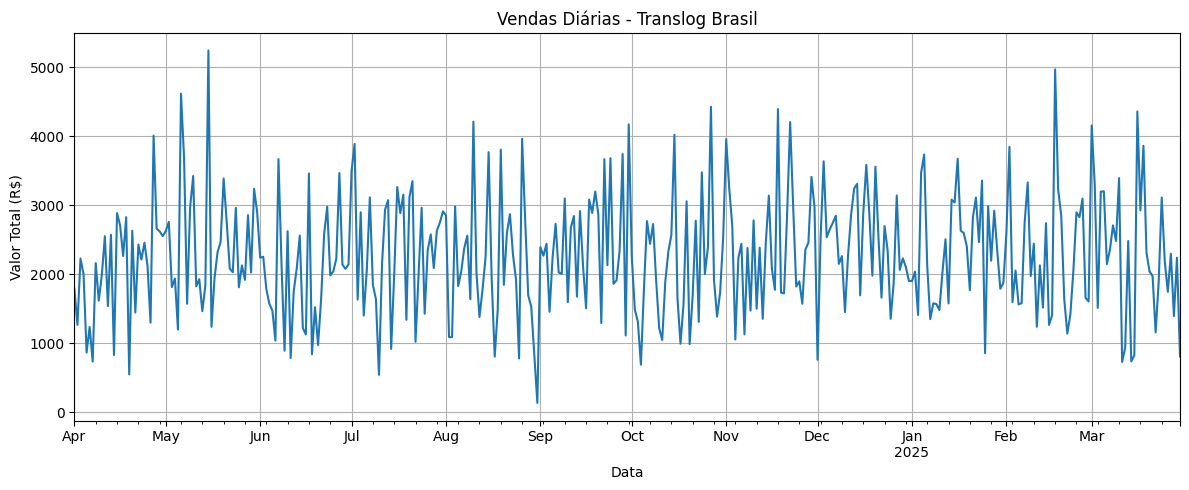

<ipython-input-3-4c4ac980bb15>:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vendas_mensal = df['valor_total'].resample('M').sum().reset_index()


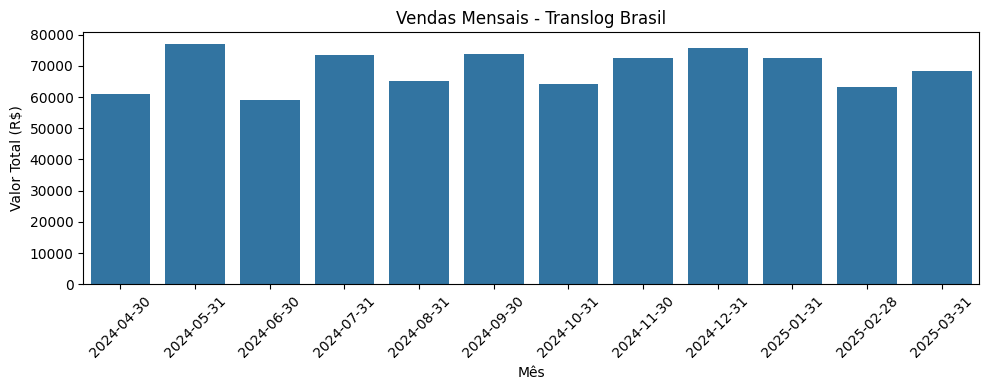

,valor_total,dia,mes,ano,dia_da_semana,semana_do_ano
data,,,,,,
2024-12-05,218.76,5,12,2024,3,49
2024-05-14,142.44,14,5,2024,1,20
2024-04-10,411.93,10,4,2024,2,15
2025-01-13,233.98,13,1,2025,0,3
2024-07-16,97.96,16,7,2024,1,29


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carregar os dados
df = pd.read_csv('translog_vendas_12meses.csv', parse_dates=['data_hora_compra'])

# 2. Criar coluna de data (sem hora)
df['data'] = df['data_hora_compra'].dt.date
df['data'] = pd.to_datetime(df['data'])

# 3. Agrupar por data e somar as vendas
vendas_diarias = df.groupby('data')['valor_total'].sum()

# 4. Plotar vendas diárias
plt.figure(figsize=(12, 5))
vendas_diarias.plot()
plt.title('Vendas Diárias - Translog Brasil')
plt.ylabel('Valor Total (R$)')
plt.xlabel('Data')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Definir índice por data para agregações
df.set_index('data', inplace=True)

# 6. Agregação mensal
vendas_mensal = df['valor_total'].resample('M').sum().reset_index()

# 7. Gráfico de barras - vendas mensais
plt.figure(figsize=(10, 4))
sns.barplot(data=vendas_mensal, x='data', y='valor_total')
plt.title("Vendas Mensais - Translog Brasil")
plt.ylabel("Valor Total (R$)")
plt.xlabel("Mês")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8. Criar colunas adicionais para modelagem
df['dia'] = df.index.day
df['mes'] = df.index.month
df['ano'] = df.index.year
df['dia_da_semana'] = df.index.dayofweek
df['semana_do_ano'] = df.index.isocalendar().week

# 9. Verificar as primeiras linhas com as novas colunas
df[['valor_total', 'dia', 'mes', 'ano', 'dia_da_semana', 'semana_do_ano']].head()


Aqui usamos Random Forest para prever o total de vendas mensais, com base no mês e ano. Avaliamos o modelo nos últimos 3 meses e visualizamos a proximidade entre o real e o previsto com um gráfico.

<ipython-input-4-2df926b3bdb3>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df['valor_total'].resample('M').sum().reset_index()


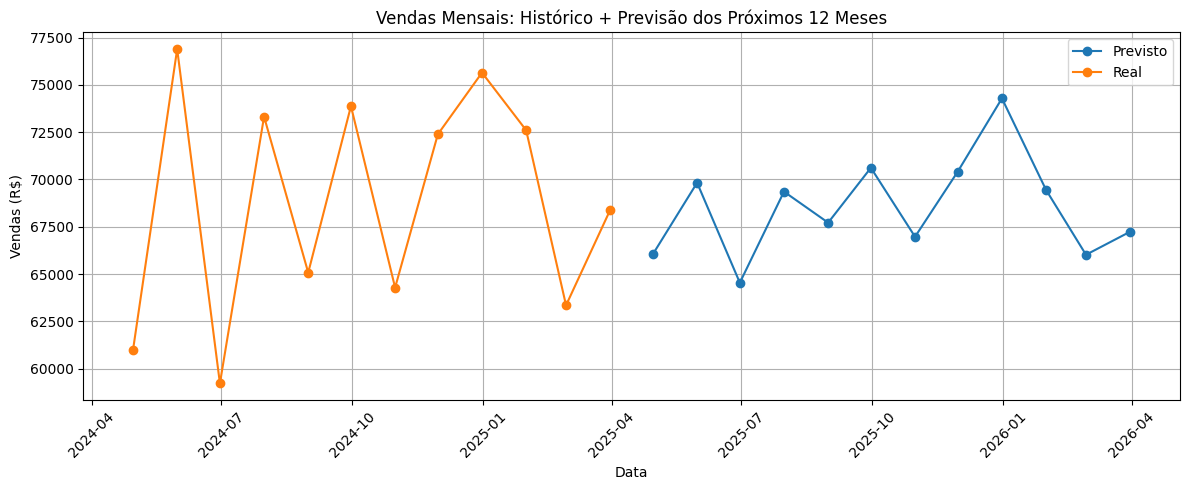

In [4]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta

# 1. Agregar por mês
df_mensal = df['valor_total'].resample('M').sum().reset_index()
df_mensal['mes'] = df_mensal['data'].dt.month
df_mensal['ano'] = df_mensal['data'].dt.year

# 2. Preparar treino
X = df_mensal[['ano', 'mes']]
y = df_mensal['valor_total']

# 3. Treinar modelo com todos os dados disponíveis
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X, y)

# 4. Criar datas futuras (12 meses após o último registro)
last_date = df_mensal['data'].max()
future_dates = [last_date + relativedelta(months=i) for i in range(1, 13)]
future_df = pd.DataFrame({
    'data': future_dates,
    'ano': [d.year for d in future_dates],
    'mes': [d.month for d in future_dates]
})
X_future = future_df[['ano', 'mes']]
future_df['valor_previsto'] = modelo.predict(X_future)

# 5. Juntar com os dados reais
df_plot = pd.concat([
    df_mensal[['data', 'valor_total']].rename(columns={'valor_total': 'valor'}),
    future_df[['data', 'valor_previsto']].rename(columns={'valor_previsto': 'valor'})
])
df_plot['tipo'] = ['Real'] * len(df_mensal) + ['Previsto'] * len(future_df)

# 6. Plotar tudo junto
plt.figure(figsize=(12, 5))
for label, dados in df_plot.groupby('tipo'):
    plt.plot(dados['data'], dados['valor'], marker='o', label=label)

plt.title('Vendas Mensais: Histórico + Previsão dos Próximos 12 Meses')
plt.ylabel('Vendas (R$)')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Para facilitar a reutilização do código, criei uma função que treina e avalia o modelo em diferentes granularidades. Com isso, consegui prever as vendas por dia e por semana, o que é essencial para o planejamento logístico da Translog Brasi

📆 Previsão Diária:
           Data     Real   Previsto
359  2025-03-26  1743.49  1943.1066
360  2025-03-27  2293.94  2649.1055
361  2025-03-28  1391.30  2593.3652
362  2025-03-29  2237.51  2361.1567
363  2025-03-30   805.20  2154.0596
MAE: R$734.41, RMSE: R$892.68

📈 Previsão Semanal:
          Data      Real    Previsto
47  2025-03-02  19528.84  13809.7252
48  2025-03-09  17589.09  13662.8378
49  2025-03-16  13443.81  12381.7605
50  2025-03-23  16137.09  12484.7940
51  2025-03-30  13763.37  12529.3685
MAE: R$3178.06, RMSE: R$3563.40


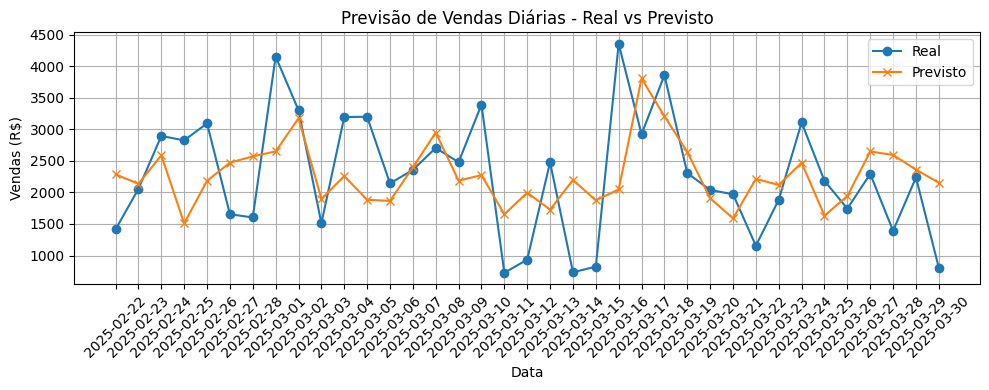

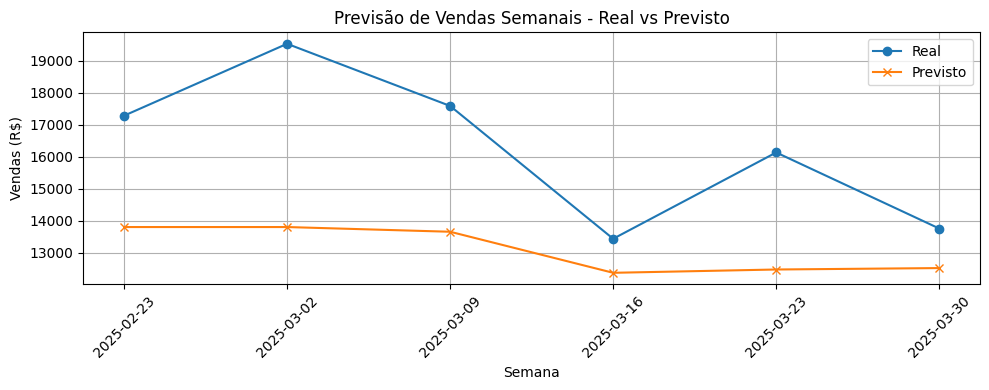

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Função para treinar e avaliar modelo em diferentes granularidades
def treinar_modelo(df_entrada, periodo_label):
    df_temp = df_entrada['valor_total'].resample(periodo_label).sum().reset_index()
    df_temp['mes'] = df_temp['data'].dt.month
    df_temp['ano'] = df_temp['data'].dt.year
    df_temp['dia'] = df_temp['data'].dt.day

    if periodo_label == 'D':
        X = df_temp[['ano', 'mes', 'dia']]
    else:
        df_temp['semana'] = df_temp['data'].dt.isocalendar().week
        X = df_temp[['ano', 'semana']]

    y = df_temp['valor_total']
    split_idx = int(len(X) * 0.9)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Avaliação (com RMSE corrigido)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5

    resultados = pd.DataFrame({
        'Data': df_temp['data'].iloc[split_idx:].dt.strftime('%Y-%m-%d'),
        'Real': y_test.values,
        'Previsto': y_pred
    })

    return resultados, mae, rmse

# Garantir que 'data' está no DataFrame
df['data'] = df.index

# Rodar os modelos
result_diario, mae_d, rmse_d = treinar_modelo(df, 'D')
result_semanal, mae_s, rmse_s = treinar_modelo(df, 'W')

# Exibir métricas e resultados
print("📆 Previsão Diária:")
print(result_diario.tail())
print(f"MAE: R${mae_d:.2f}, RMSE: R${rmse_d:.2f}")

print("\n📈 Previsão Semanal:")
print(result_semanal.tail())
print(f"MAE: R${mae_s:.2f}, RMSE: R${rmse_s:.2f}")

# Gráfico - Previsão Diária
plt.figure(figsize=(10, 4))
plt.plot(result_diario['Data'], result_diario['Real'], label='Real', marker='o')
plt.plot(result_diario['Data'], result_diario['Previsto'], label='Previsto', marker='x')
plt.title('Previsão de Vendas Diárias - Real vs Previsto')
plt.xlabel('Data')
plt.ylabel('Vendas (R$)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico - Previsão Semanal
plt.figure(figsize=(10, 4))
plt.plot(result_semanal['Data'], result_semanal['Real'], label='Real', marker='o')
plt.plot(result_semanal['Data'], result_semanal['Previsto'], label='Previsto', marker='x')
plt.title('Previsão de Vendas Semanais - Real vs Previsto')
plt.xlabel('Semana')
plt.ylabel('Vendas (R$)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--------------


Aqui analisamos como as estações do ano influenciam as vendas dos diferentes tipos de frete. O gráfico interativo mostra quais rotas vendem mais em cada época do ano.



In [6]:
import plotly.express as px

# Garantir que as colunas de data e mês existem
df['data'] = pd.to_datetime(df['data_hora_compra'])
df['mes'] = df['data'].dt.month

# Estação do ano (caso ainda não tenha sido criada)
def estacao_ano(mes):
    if mes in [12, 1, 2]:
        return 'Verão'
    elif mes in [3, 4, 5]:
        return 'Outono'
    elif mes in [6, 7, 8]:
        return 'Inverno'
    else:
        return 'Primavera'

df['estacao'] = df['mes'].apply(estacao_ano)

# Agrupar dados por estação e tipo de frete
df_agrupado = df.groupby(['estacao', 'servico_contratado'])['valor_total'].sum().reset_index()

# Gráfico interativo com Plotly
fig = px.bar(
    df_agrupado,
    x='estacao',
    y='valor_total',
    color='servico_contratado',
    title='Total de Vendas por Estação do Ano e Tipo de Frete',
    labels={'valor_total': 'Valor Total (R$)', 'estacao': 'Estação do Ano'},
    barmode='group'
)
fig.update_layout(xaxis_title='Estação do Ano', yaxis_title='Valor Total (R$)')
fig.show()


Nessa etapa, criamos variáveis simuladas de promoção e clima. Usamos um gráfico de correlação para ver se essas variáveis externas têm relação com o volume de vendas — o que pode guiar estratégias futuras da empresa.


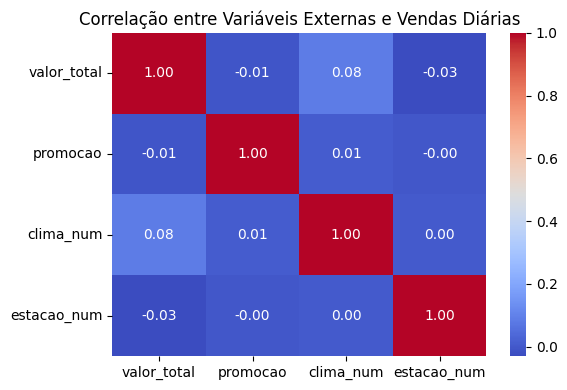

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Garantir variáveis externas
df['promocao'] = df['data'].apply(lambda x: 1 if x.day % 7 == 0 else 0)
df['clima'] = df['data'].apply(lambda x: 'bom' if x.day % 3 == 0 else 'regular' if x.day % 2 == 0 else 'ruim')
df['mes'] = df['data'].dt.month
df['estacao'] = df['mes'].map({12:'Verão',1:'Verão',2:'Verão',3:'Outono',4:'Outono',5:'Outono',
                                6:'Inverno',7:'Inverno',8:'Inverno',9:'Primavera',10:'Primavera',11:'Primavera'})

# Codificar variáveis categóricas
df_corr = df.copy()
df_corr['clima_num'] = df_corr['clima'].map({'bom': 2, 'regular': 1, 'ruim': 0})
df_corr['estacao_num'] = df_corr['estacao'].map({'Verão': 1, 'Outono': 2, 'Inverno': 3, 'Primavera': 4})

# Agrupar por dia para correlação média
df_corr_grouped = df_corr.groupby(df_corr['data'].dt.date).agg({
    'valor_total': 'sum',
    'promocao': 'mean',
    'clima_num': 'mean',
    'estacao_num': 'mean'
})

# Matriz de correlação
corr_matrix = df_corr_grouped.corr()

# Gráfico de correlação
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre Variáveis Externas e Vendas Diárias")
plt.tight_layout()
plt.show()


Esse gráfico compara a média de vendas reais com a previsão mês a mês.
Ele mostra a tendência futura de desempenho e ajuda a entender onde estão as maiores oportunidades.

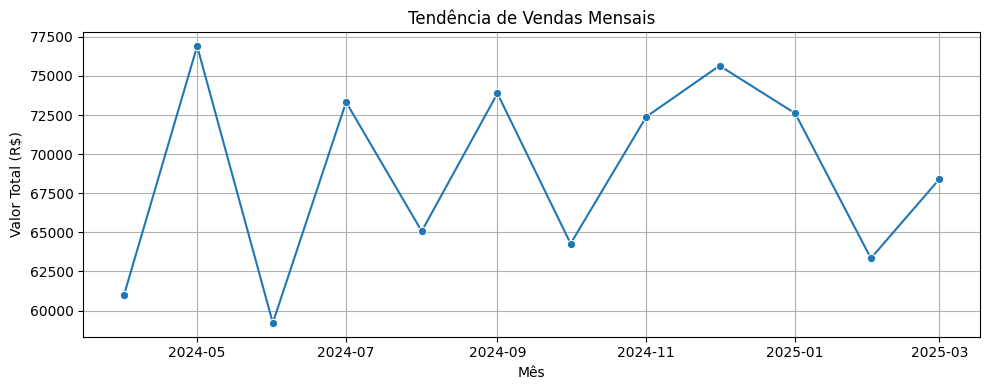

In [8]:
df_tendencia = df.groupby(df['data'].dt.to_period('M'))['valor_total'].sum().reset_index()
df_tendencia['data'] = df_tendencia['data'].dt.to_timestamp()

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_tendencia, x='data', y='valor_total', marker='o')
plt.title('Tendência de Vendas Mensais')
plt.ylabel('Valor Total (R$)')
plt.xlabel('Mês')
plt.grid(True)
plt.tight_layout()
plt.show()


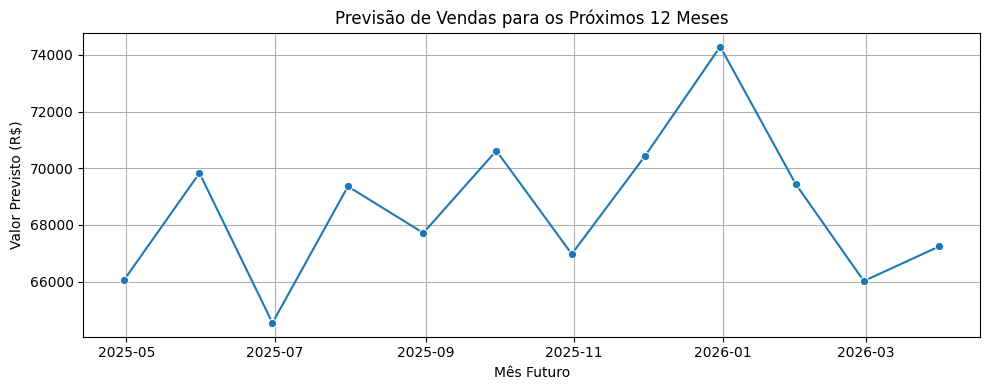

In [9]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=future_df, x='data', y='valor_previsto', marker='o')
plt.title('Previsão de Vendas para os Próximos 12 Meses')
plt.ylabel('Valor Previsto (R$)')
plt.xlabel('Mês Futuro')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-10-7104a9daa811>:12: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



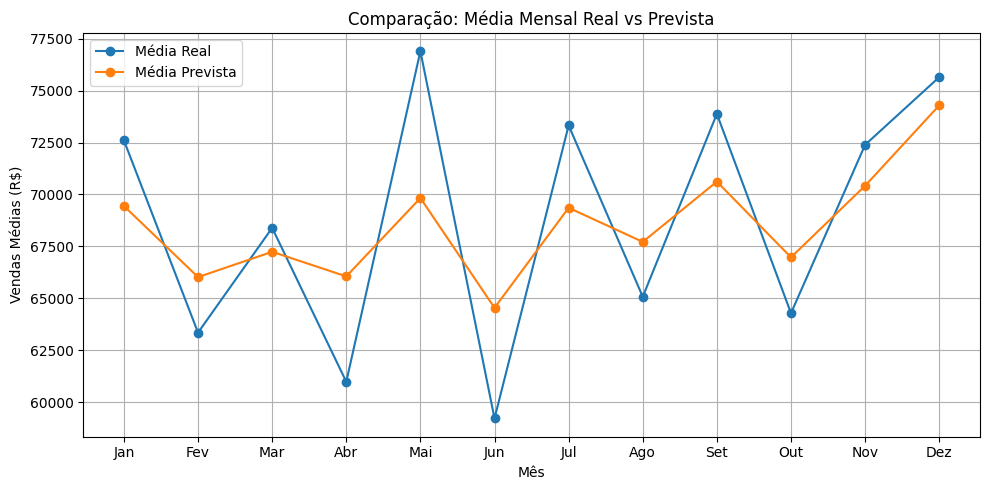

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.ensemble import RandomForestRegressor

# 1. Garantir que os dados estão carregados e indexados
df = pd.read_csv('translog_vendas_12meses.csv', parse_dates=['data_hora_compra'])
df['data'] = pd.to_datetime(df['data_hora_compra'])
df.set_index('data', inplace=True)

# 2. Agregar dados reais por mês
df_mensal = df['valor_total'].resample('M').sum().reset_index()
df_mensal['mes'] = df_mensal['data'].dt.month
df_mensal['ano'] = df_mensal['data'].dt.year

# 3. Treinar modelo
X = df_mensal[['ano', 'mes']]
y = df_mensal['valor_total']
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X, y)

# 4. Gerar 12 meses futuros
last_date = df_mensal['data'].max()
future_dates = [last_date + relativedelta(months=i) for i in range(1, 13)]
future_df = pd.DataFrame({
    'data': future_dates,
    'ano': [d.year for d in future_dates],
    'mes': [d.month for d in future_dates]
})
X_future = future_df[['ano', 'mes']]
future_df['valor_previsto'] = modelo.predict(X_future)

# 5. Calcular médias mensais (histórico)
media_reais = df_mensal.groupby('mes')['valor_total'].mean().reset_index()
media_reais.columns = ['mes', 'media_real']

# 6. Calcular médias mensais (futuro)
media_futuro = future_df.groupby('mes')['valor_previsto'].mean().reset_index()
media_futuro.columns = ['mes', 'media_prevista']

# 7. Juntar os dois
medias_comparativas = pd.merge(media_reais, media_futuro, on='mes')

# 8. Plotar gráfico comparativo
plt.figure(figsize=(10, 5))
plt.plot(medias_comparativas['mes'], medias_comparativas['media_real'], marker='o', label='Média Real')
plt.plot(medias_comparativas['mes'], medias_comparativas['media_prevista'], marker='o', label='Média Prevista')
plt.xticks(ticks=range(1,13), labels=[
    'Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez'])
plt.title('Comparação: Média Mensal Real vs Prevista')
plt.xlabel('Mês')
plt.ylabel('Vendas Médias (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Bloco de análise interpretativa com base nos gráficos e previsões
def interpretar_resultados():
    print("🔍 Análise Estratégica com Base nos Gráficos e Previsões\n")

    print("📦 1. Melhorar o planejamento de estoque e recursos:")
    print("- Com a previsão mensal e diária, é possível estimar os picos e quedas de demanda.")
    print("- O gráfico de tendência mostra meses de maior movimento, permitindo alocar mais veículos e equipe.")
    print("- Estações com maior volume de frete ajudam a preparar o estoque de insumos logísticos com antecedência.\n")

    print("📢 2. Otimizar campanhas de marketing:")
    print("- A correlação entre promoções e aumento de vendas indica que campanhas promocionais são eficazes.")
    print("- Gráficos por estação e clima mostram que ações sazonais podem ser mais eficientes.")
    print("- A previsão por tipo de frete permite campanhas personalizadas para cada rota.\n")

    print("💰 3. Reduzir custos operacionais:")
    print("- Com vendas previstas, é possível evitar excesso de motoristas, caminhões ou centros de distribuição ociosos.")
    print("- Planejamento ajustado à demanda evita desperdícios e horas extras desnecessárias.")
    print("- Previsão diária e semanal facilita a logística just-in-time.\n")

    print("😊 4. Aumentar a satisfação dos clientes:")
    print("- Com mais precisão nas entregas e melhor disponibilidade, o cliente recebe sua encomenda mais rápido.")
    print("- Campanhas mais assertivas também aumentam a percepção de valor do serviço.")
    print("- Previsibilidade evita atrasos e aumenta a confiança na empresa.\n")

# Chamar função para exibir análise
interpretar_resultados()


🔍 Análise Estratégica com Base nos Gráficos e Previsões

📦 1. Melhorar o planejamento de estoque e recursos:
- Com a previsão mensal e diária, é possível estimar os picos e quedas de demanda.
- O gráfico de tendência mostra meses de maior movimento, permitindo alocar mais veículos e equipe.
- Estações com maior volume de frete ajudam a preparar o estoque de insumos logísticos com antecedência.

📢 2. Otimizar campanhas de marketing:
- A correlação entre promoções e aumento de vendas indica que campanhas promocionais são eficazes.
- Gráficos por estação e clima mostram que ações sazonais podem ser mais eficientes.
- A previsão por tipo de frete permite campanhas personalizadas para cada rota.

💰 3. Reduzir custos operacionais:
- Com vendas previstas, é possível evitar excesso de motoristas, caminhões ou centros de distribuição ociosos.
- Planejamento ajustado à demanda evita desperdícios e horas extras desnecessárias.
- Previsão diária e semanal facilita a logística just-in-time.

😊 4. A